# A Rough Win Probability Model

This notebook provides an example of how python and scikit-learn can be used to determine win probabilities for the superbowl.  The model is based off of play-by-play data for seasons 1999-2021.

## Prep

First, I'll import the required libraries and initialize a connection to the database:

In [5]:
from data_loader import connect_to_db
from os import getenv
import pandas as pd
import sqlalchemy
import pyodbc
import urllib
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

pyodbc.pooling = False

server = getenv('DB_SERVER')
database = getenv('DB_NAME')
user = getenv('DB_USER')
password = getenv('DB_PW')


class DBConnect:
    def __init__(self, user, password, host, database):
        self.username = user
        self.password = password
        self.db_host = host
        self.database = database
        self.connection_string = 'mssql+pyodbc:///?odbc_connect={}'.format(
            urllib.parse.quote_plus(
                f'DSN={self.db_host};DATABASE={self.database};UID={self.username};PWD={self.password}'
            )
        )
        self.engine = sqlalchemy.create_engine(self.connection_string, fast_executemany=True)


In [6]:
engine = DBConnect(user, password, server, database).engine
conn = engine.connect()

## Query The Database

Next, I'll query the database table `pbp_data`, which contains the desired play-by-play data for all seasons, and sort the data for easier parsing:

In [7]:
sql_query = """
SELECT * FROM pbp_data
"""

In [8]:
data = pd.read_sql_query(sql_query, conn)
data.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2001_01_ATL_SF,2001090900,SF,ATL,REG,1,None,None,None,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.0,2001_01_ATL_SF,2001090900,SF,ATL,REG,1,SF,home,ATL,...,0.0,1.0,0.586625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57.0,2001_01_ATL_SF,2001090900,SF,ATL,REG,1,SF,home,ATL,...,0.0,1.0,0.232765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,271.0,2001_01_ATL_SF,2001090900,SF,ATL,REG,1,ATL,away,SF,...,0.0,1.0,0.319147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78.0,2001_01_ATL_SF,2001090900,SF,ATL,REG,1,SF,home,ATL,...,0.0,1.0,-0.457066,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data = data.sort_values(by=['season', 'week', 'game_id', 'play_id'])

## Calculate the EWMA

To begin prepping the model, I want to build a function that calculates the expected points added (EPA), and then categorize EPA into rushing offensive/defensive plays, and passing offensive/defensive plays.  I'll then finish off by merging the updated data into two categories; rushing and passing EPA:

In [27]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)


def get_epa(df, mode, play_type):
    return df.loc[df[play_type] == 1, :].groupby([mode, 'season', 'week'], as_index=False)['epa'].mean()


# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = get_epa(data, 'posteam', 'rush_attempt')
rushing_defense_epa = get_epa(data, 'defteam', 'rush_attempt')
passing_offense_epa = get_epa(data, 'posteam', 'pass_attempt')
passing_defense_epa = get_epa(data, 'defteam', 'pass_attempt')


def lag_epa_one_period(df, mode):
    return df.groupby(mode)['epa'].shift()


# lag EPA one period back
rushing_offense_epa['epa_shifted'] = lag_epa_one_period(rushing_offense_epa, 'posteam')
rushing_defense_epa['epa_shifted'] = lag_epa_one_period(rushing_defense_epa, 'defteam')
passing_offense_epa['epa_shifted'] = lag_epa_one_period(passing_offense_epa, 'posteam')
passing_defense_epa['epa_shifted'] = lag_epa_one_period(passing_defense_epa, 'defteam')


def calculate_ewma(df, mode):
    return df.groupby(mode)['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

def calculate_dynamic_window_ewma(df, mode):
    return df.groupby(mode).apply(dynamic_window_ewma).values
# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = calculate_ewma(rushing_offense_epa, 'posteam')
rushing_offense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(rushing_offense_epa, 'posteam')

rushing_defense_epa['ewma'] = calculate_ewma(rushing_defense_epa, 'defteam')
rushing_defense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(rushing_defense_epa, 'defteam')

passing_offense_epa['ewma'] = calculate_ewma(passing_offense_epa, 'posteam')
passing_offense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(passing_offense_epa, 'posteam')

passing_defense_epa['ewma'] = calculate_ewma(passing_defense_epa, 'defteam')
passing_defense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(passing_defense_epa, 'defteam')


def merge_data(rush_df, pass_df, mode):
    return rush_df.merge(pass_df, on=[mode, 'season', 'week'], suffixes=('_rushing', '_passing')).rename(columns={mode: 'team'})

#Merge all the data together
offense_epa = merge_data(rushing_offense_epa, passing_offense_epa, 'posteam')
defense_epa = merge_data(rushing_defense_epa, passing_defense_epa, 'defteam')

epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

,team,season,week,epa_rushing_offense,epa_shifted_rushing_offense,ewma_rushing_offense,ewma_dynamic_window_rushing_offense,epa_passing_offense,epa_shifted_passing_offense,ewma_passing_offense,ewma_dynamic_window_passing_offense,epa_rushing_defense,epa_shifted_rushing_defense,ewma_rushing_defense,ewma_dynamic_window_rushing_defense,epa_passing_defense,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,-0.345669,-0.068545,-0.109518,-0.109518,0.019830,0.056256,-0.172588,-0.172588,0.166199,0.363190,0.086016,0.086016,-0.009200,0.269840,0.115978,0.115978
1,ARI,2000,2,-0.276743,-0.345669,-0.153920,-0.153920,0.558977,0.019830,-0.136410,-0.136410,-0.065981,0.166199,0.101092,0.101092,0.283460,-0.009200,0.092441,0.092441
2,ARI,2000,4,-0.334533,-0.276743,-0.176871,-0.176871,-0.264054,0.558977,-0.006468,-0.006468,-0.018524,-0.065981,0.069872,0.069872,0.500345,0.283460,0.128136,0.128136
3,ARI,2000,5,-0.016838,-0.334533,-0.206184,-0.206184,0.049141,-0.264054,-0.054359,-0.054359,0.004625,-0.018524,0.053437,0.053437,0.058499,0.500345,0.197339,0.197339
4,ARI,2000,6,-0.038473,-0.016838,-0.171124,-0.171124,0.101830,0.049141,-0.035195,-0.035195,0.086308,0.004625,0.044399,0.044399,-0.063633,0.058499,0.171631,0.171631


In [28]:
epa.to_sql('epa', conn, index=False, if_exists='replace')

## Plot Expected Points Added Results

Since we have our epa, let's see what the results look like:

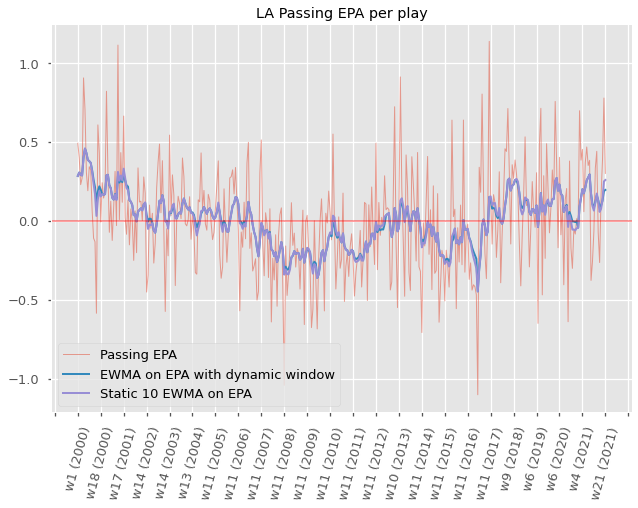

In [29]:
def plot_epa(df, team):
    tm = df.loc[df['team'] == team, :].assign(
        season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
    ).set_index('season_week')
    fig, ax = plt.subplots()
    loc = plticker.MultipleLocator(base=16)
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(axis='x', rotation=75)
    ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
    ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
    ax.plot(tm['ewma_passing_offense'], lw=2);
    plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)
    ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
    ax.set_title(f'{team} Passing EPA per play')
    return plt

fig = plot_epa(epa, 'LA')

This plot visualizes the variability of the EPA of the LA Rams per play.  It shows that the Rams have trended slightly upward in expected points gained per play.  If we compare this to the Bengals, we see a bit different picture:

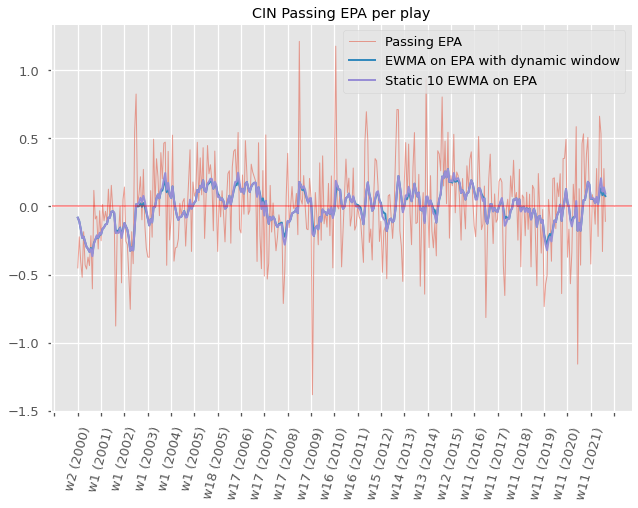

In [30]:
fig = plot_epa(epa, 'CIN')

We can see that the Bengals trails slightly behind the Rams in EPA per play.  From the visual indicators, it seems like the Rams have a slight edge in EPA over the Bengals.

## Gather Historic Match Schedules

Next, I'll create a dataframe that captures the season schedule stats for all available match data:

In [31]:
def get_schedule(dataset_df, epa_df):
    schedule = dataset_df[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True).assign(
        home_team_win = lambda x: (x.home_score > x.away_score).astype(int))
    return schedule.merge(epa_df.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week']).merge(
        epa_df.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df = get_schedule(data, epa)

df.head()

,season,week,home_team,away_team,home_score,away_score,home_team_win,epa_rushing_offense_home,epa_shifted_rushing_offense_home,ewma_rushing_offense_home,...,ewma_passing_offense_away,ewma_dynamic_window_passing_offense_away,epa_rushing_defense_away,epa_shifted_rushing_defense_away,ewma_rushing_defense_away,ewma_dynamic_window_rushing_defense_away,epa_passing_defense_away,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000,1,NYG,ARI,21,16,1,0.166199,0.162852,-0.105274,...,-0.172588,-0.172588,0.166199,0.363190,0.086016,0.086016,-0.009200,0.269840,0.115978,0.115978
1,2000,1,PIT,BAL,0,16,0,-0.499352,-0.643877,-0.117606,...,-0.115063,-0.115063,-0.499352,-0.241927,-0.205927,-0.205927,-0.216112,-0.314740,-0.201637,-0.201637
2,2000,1,WAS,CAR,20,17,1,-0.006129,-0.390855,-0.060330,...,0.187536,0.187536,-0.006129,0.060270,0.057299,0.057299,0.147979,-0.368611,0.001226,0.001226
3,2000,1,MIN,CHI,30,27,1,0.283000,-0.163698,-0.066504,...,-0.079538,-0.079538,0.283000,-0.130394,-0.057451,-0.057451,0.124496,0.365886,0.105317,0.105317
4,2000,1,LA,DEN,41,36,1,-0.106372,-0.692095,-0.259090,...,-0.018102,-0.018102,-0.106372,-0.110182,-0.091645,-0.091645,0.400226,-0.078273,-0.086851,-0.086851


## Determine Feature Importance

Since I separated scoring plays into various categories, we can use these to determine what "feature" (or category of play) is most likely to result in added points. I'm also going to isolate the feature query to home team wins.  Finally, I'll determine the accuracy of the most important feature:

In [32]:
def get_most_important_features(df, target):
    features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
    return features
    
features = get_most_important_features(df, 'home_team_win')
print(features)
    
target = 'home_team_win'

['ewma_dynamic_window_rushing_offense_home', 'ewma_dynamic_window_passing_offense_home', 'ewma_dynamic_window_rushing_defense_home', 'ewma_dynamic_window_passing_defense_home', 'ewma_dynamic_window_rushing_offense_away', 'ewma_dynamic_window_passing_offense_away', 'ewma_dynamic_window_rushing_defense_away', 'ewma_dynamic_window_passing_defense_away']


In [33]:
def get_data_with_features(df, features, season):
    df = df.dropna()
    X = df.loc[df['season'] != season, features].values
    y = df.loc[df['season'] != season, target].values
    clf = LogisticRegression()
    clf.fit(X, y)
    return X, y, clf

X, y, clf = get_data_with_features(df, features, '2021')

In [34]:
def get_accuracy_scores(X, y, clf, cv, scoring):
    accuracy_scores = cross_val_score(clf, X, y, cv=cv)
    log_losses = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
    print('Model Accuracy:', np.mean(accuracy_scores))
    print('Neg log loss:', np.mean(log_losses))
    return accuracy_scores, log_losses

accuracy_scores, log_losses = get_accuracy_scores(X, y, clf, 10, 'neg_log_loss')

Model Accuracy: 0.6350140226448332
Neg log loss: -0.6389147080939207


Here we can see that the Model accuracy is currently at around 63.5%.  That's not great, but this is a first try.

# Plot Most Important Features

Let's visualize the results of the feature analysis:

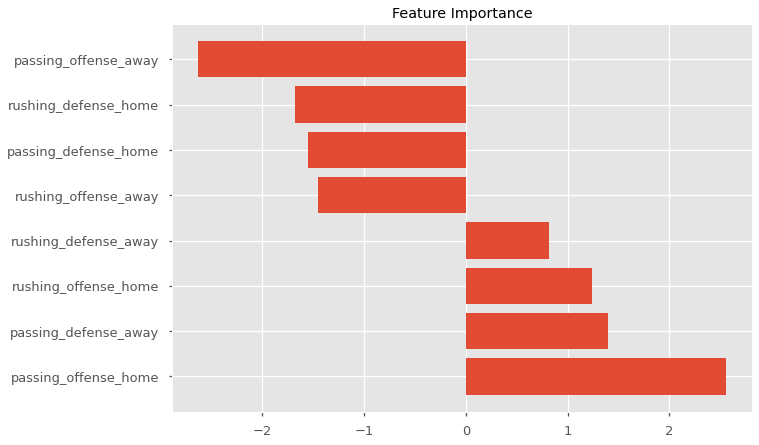

In [35]:
def plot_most_important_features(features, clf):
    fig, ax = plt.subplots()
    feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]
    coef_ = clf.coef_[0]
    features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)
    features_sorted = [feature for feature, _ in features_coef_sorted]
    coef_sorted = [coef for _, coef in features_coef_sorted]
    ax.set_title('Feature Importance')
    ax.barh(features_sorted, coef_sorted)
    plt.show()
    return plt

feature_fig = plot_most_important_features(features, clf)

We can clearly see that by far passing offense by far and away is the best indicator of points added.  Given this information, I think we've got the basis for creating the prediction model.

## Create the Model

Next, I'm going to create a function to predict match outcomes for the entire season, and get the results for 2021:

In [36]:
def predict_season(df, season, clf, features):
    season_df = df.loc[(df['season'] == season)].assign(
        predicted_winner = lambda x: clf.predict(x[features]), 
        home_team_win_probability = lambda x: clf.predict_proba(x[features])[:,1])[
        ['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]
    season_df['actual_winner'] = season_df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
    season_df['predicted_winner'] = season_df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
    season_df['win_probability'] = season_df.apply(
        lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
    season_df['correct_prediction'] = (season_df['predicted_winner'] == season_df['actual_winner']).astype(int)
    season_df = season_df.drop(columns=['home_team_win_probability', 'home_team_win'])
    return season_df.sort_values(by='win_probability', ascending=False).reset_index(drop=True)
    

df_2021 = predict_season(df, 2021, clf, features)
df_2021.head(30)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,LA,DET,7,LA,LA,0.845297,1
1,ARI,CAR,10,ARI,CAR,0.839382,0
2,ARI,HOU,7,ARI,ARI,0.835764,1
3,BUF,MIA,8,BUF,BUF,0.805366,1
4,BUF,NYJ,18,BUF,BUF,0.801646,1
5,TB,CAR,18,TB,TB,0.799663,1
6,IND,JAX,10,IND,IND,0.799502,1
7,SF,HOU,17,SF,SF,0.794758,1
8,HOU,LA,8,LA,LA,0.792734,1
9,BUF,ATL,17,BUF,BUF,0.790277,1


Given that we now have a working model, we can begin to analyze the accuracy of each prediction:

In [37]:
def get_correct_predictions(df):
    correct = df.loc[df['correct_prediction'] == 1].groupby('week')['correct_prediction'].sum()
    num_games = df.groupby('week')['correct_prediction'].size()
    return correct / num_games

results = get_correct_predictions(df_2021)
results

week
1     0.500000
2     0.625000
3     0.625000
4     0.625000
5     0.812500
6     0.642857
7     0.769231
8     0.466667
9     0.357143
10    0.357143
11    0.600000
12    0.666667
13    0.571429
14    0.857143
15    0.562500
16    0.562500
17    0.750000
18    0.562500
19    0.833333
20    0.250000
21    0.500000
Name: correct_prediction, dtype: float64

The results aren't spectacular, but given the nature of the season, there's a lot left wanting from the 2021 season in general.  But we can then use this to generate a dataframe that includes the match results, predicted outcome, and win probability of an entire season:

In [38]:
def get_season_prediction_outcomes(df):
    return df.loc[df['week'] == results.idxmax()].sort_values(by='win_probability', ascending=False)
get_season_prediction_outcomes(df_2021)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
16,GB,CHI,14,GB,GB,0.769516,1
54,TEN,JAX,14,TEN,TEN,0.702074,1
70,LAC,NYG,14,LAC,LAC,0.688509,1
75,DEN,DET,14,DEN,DEN,0.678865,1
95,KC,LV,14,KC,KC,0.654769,1
106,MIN,PIT,14,MIN,MIN,0.645761,1
115,CAR,ATL,14,CAR,ATL,0.636058,0
118,ARI,LA,14,ARI,LA,0.630524,0
144,HOU,SEA,14,SEA,SEA,0.613167,1
206,CIN,SF,14,SF,SF,0.564310,1


In [39]:
def get_full_season_prediction_outcomes(df):
    return df.loc[df['week'] > 17]

get_full_season_prediction_outcomes(df_2021)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
4,BUF,NYJ,18,BUF,BUF,0.801646,1
5,TB,CAR,18,TB,TB,0.799663,1
18,KC,PIT,19,KC,KC,0.764971,1
31,DET,GB,18,GB,DET,0.737336,0
40,JAX,IND,18,IND,JAX,0.718747,0
65,KC,CIN,21,KC,CIN,0.692925,0
78,TB,PHI,19,TB,TB,0.675981,1
91,DEN,KC,18,KC,KC,0.662450,1
104,HOU,TEN,18,TEN,TEN,0.647292,1
122,CIN,LV,19,CIN,CIN,0.627602,1


## Create a prediction model for the Superbowl

Finally, I'm going to create a way to calculate EWMA for a given window, and then create a function that predicts the outcome of a match given two teams are matched against each other:

In [40]:
import itertools

def ewma(data, window):
    """
    Calculate the most recent value for EWMA given an array of data and a window size
    """
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    scale = 1 / alpha_rev
    n = data.shape[0]
    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0] * alpha_rev**(r+1)
    pw0 = alpha * alpha_rev**(n-1)
    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out[-1]

def get_superbowl_predictions(df, season, home, away, clf):
    sb_df = df.loc[(df['season'] == season)]
    offense = sb_df.loc[(sb_df['posteam'] == home) | (sb_df['posteam'] == away)]
    defense = sb_df.loc[(sb_df['defteam'] == home) | (sb_df['defteam'] == away)]
    rushing_offense = offense.loc[offense['rush_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)['epa'].mean().rename(columns={'posteam': 'team'})
    passing_offense = offense.loc[offense['pass_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)['epa'].mean().rename(columns={'posteam': 'team'})
    rushing_defense = defense.loc[defense['rush_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)['epa'].mean().rename(columns={'defteam': 'team'})
    passing_defense = defense.loc[defense['pass_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)['epa'].mean().rename(columns={'defteam': 'team'})    
    super_bowl = np.zeros(8)
    
    for i, (tm, stat_df) in enumerate(itertools.product([home, away], [rushing_offense, passing_offense, rushing_defense, passing_defense])):
        ewma_value = ewma(stat_df.loc[stat_df['team'] == tm]['epa'].values, 20)
        super_bowl[i] = ewma_value
        
    predicted_winner = clf.predict(super_bowl.reshape(1, 8))[0]
    predicted_proba = clf.predict_proba(super_bowl.reshape(1, 8))[0]
    winner = home if predicted_winner else away
    win_prob = predicted_proba[-1] if predicted_winner else predicted_proba[0]
    print(f'Model predicts {winner} will win the Super Bowl and has a {round(win_prob*100, 2)}% win probability')


get_superbowl_predictions(data, 2021, 'LA', 'CIN', clf)

Model predicts LA will win the Super Bowl and has a 67.62% win probability


## Results

Suspicions were confirmed that the Rams would be predicted to win.  We'll need to see how it goes before my confidence increases in the model.  On the other hand, 538's ELO WP model shows a [win probability of 68%](https://projects.fivethirtyeight.com/2021-nfl-predictions/games/), so maybe it's not so bad for a first iteration WP model?